In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE


import lightgbm as lgbm


sns.set_style("whitegrid")
sns.set_palette('muted')

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [3]:
data_loc = '/kaggle/input/playground-series-s4e1/'
train = pd.read_csv(data_loc + 'train.csv')
test = pd.read_csv(data_loc + 'test.csv')
submission = pd.read_csv(data_loc + 'sample_submission.csv')

In [4]:
display(train.head().T)
#display(test.head().T)
#display(submission.head())

,0,1,2,3,4
id,0,1,2,3,4
CustomerId,15674932,15749177,15694510,15741417,15766172
Surname,Okwudilichukwu,Okwudiliolisa,Hsueh,Kao,Chiemenam
CreditScore,668,627,678,581,716
Geography,France,France,France,France,Spain
Gender,Male,Male,Male,Male,Male
Age,33.0,33.0,40.0,34.0,33.0
Tenure,3,1,10,2,5
Balance,0.0,0.0,0.0,148882.54,0.0
NumOfProducts,2,2,2,1,2


In [5]:
train.info()
#train.isnull().sum()
#train.describe(include='all')
train.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


id                 165034
CustomerId          23221
Surname              2797
CreditScore           457
Geography               3
Gender                  2
Age                    71
Tenure                 11
Balance             30075
NumOfProducts           4
HasCrCard               2
IsActiveMember          2
EstimatedSalary     55298
Exited                  2
dtype: int64

In [6]:
def prepare_data(df):
    
    # Make the column names lower-case
    df.columns = df.columns.str.lower()
    
    # Make the string values of categorical columns lower-case and uniform
    categorical_columns = df.dtypes[df.dtypes == 'object'].index.tolist()

    for col in categorical_columns:
        df[col] = df[col].str.lower()
    
    # Feature engineering
    df['balance_high'] = df['balance'] > 10
    
    # replace number of products greater than 2, by 3
    df['numofproducts'] = df['numofproducts'].replace(4, 3)

    bins = [18, 40, 60, 100]  # Define age bins
    labels = ['young', 'middleaged', 'senior']  # Labels for each category
    df['agecategory'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

    df['balance_credit_ratio'] = df['balance'] / df['creditscore']
    df['credit_utilization'] = df['balance'] / (df['hascrcard'] * df['creditscore'] + 1)  # Adding 1 to avoid division by zero
    df['tenure_age_ratio'] = df['tenure'] / df['age']
    df['geo_gender_interaction'] = df['geography'] + '_' + df['gender']
    
    # Binarise 'gender' and 'geography'
    df['gender'] = (df['gender'] == 'male').astype(int)
    df['geography'] = (df['geography'] == 'germany').astype(int)
    
    # numerical transformations
    for col in ['creditscore', 'age', 'balance', 'estimatedsalary']:
        df[f'{col}_square'] = df[col]*df[col]
        df[f'{col}_sqrt'] = np.sqrt(df[col])
        df[f'{col}_log'] = np.log1p(df[col])

    
    return df

train = prepare_data(train)
test = prepare_data(test)

In [7]:
dep_var = 'exited'

fe_cols = ['surname', 'customerid', 'id', 'tenure_age_ratio']
le_cols = ['gender', 'hascrcard', 'isactivemember', 'geography', 'balance_high']
ohe_cols = ['numofproducts', 'geo_gender_interaction', 'agecategory']

cat_cols = fe_cols + le_cols + ohe_cols

num_cols = ['creditscore', 'age', 'balance', 'estimatedsalary', 
            'credit_utilization', 'balance_credit_ratio',
           'creditscore_square', 'creditscore_sqrt',
           'creditscore_log', 'age_square', 'age_sqrt', 'age_log',
           'balance_square', 'balance_sqrt', 'balance_log',
           'estimatedsalary_square', 'estimatedsalary_sqrt',
           'estimatedsalary_log']

In [8]:
"""%matplotlib inline

cmap = plt.get_cmap("tab20c")
colors = cmap(range(len(cat_cols)))

fig, axs = plt.subplots(ncols=len(cat_cols), nrows=1, figsize=(int(3*len(cat_cols)+1),3))
axs = axs.flatten()

for idx, col in enumerate(cat_cols[1:] + [dep_var]):
    #display(df[col].value_counts(normalize=True))
    train[col].value_counts(normalize=True).plot.barh(ax=axs[idx], color=colors[idx], ylabel='')
    axs[idx].set_title(col)
    
fig.suptitle('Categorical Variables: Value Counts')
plt.tight_layout()

cmap = plt.get_cmap("tab20c")
colors = cmap(range(len(num_cols)))

fig, axs = plt.subplots(ncols=len(num_cols), nrows=1, figsize=(3*int(len(num_cols)),3))
axs = axs.flatten()

for idx, col in enumerate(num_cols):
    if col == 'balance':
        train[train.balance > 10][col].plot.hist(ax=axs[idx], bins=20, color=colors[idx], ylabel='')
        axs[idx].set_title('balance > 10')
    #display(df[col].value_counts(normalize=True))
    else: 
        train[col].plot.hist(ax=axs[idx], bins=20, color=colors[idx], ylabel='')
        axs[idx].set_title(col)
    
fig.suptitle('Numerical Variables: Normalised historgrams')
plt.tight_layout()"""

'%matplotlib inline\n\ncmap = plt.get_cmap("tab20c")\ncolors = cmap(range(len(cat_cols)))\n\nfig, axs = plt.subplots(ncols=len(cat_cols), nrows=1, figsize=(int(3*len(cat_cols)+1),3))\naxs = axs.flatten()\n\nfor idx, col in enumerate(cat_cols[1:] + [dep_var]):\n    #display(df[col].value_counts(normalize=True))\n    train[col].value_counts(normalize=True).plot.barh(ax=axs[idx], color=colors[idx], ylabel=\'\')\n    axs[idx].set_title(col)\n    \nfig.suptitle(\'Categorical Variables: Value Counts\')\nplt.tight_layout()\n\ncmap = plt.get_cmap("tab20c")\ncolors = cmap(range(len(num_cols)))\n\nfig, axs = plt.subplots(ncols=len(num_cols), nrows=1, figsize=(3*int(len(num_cols)),3))\naxs = axs.flatten()\n\nfor idx, col in enumerate(num_cols):\n    if col == \'balance\':\n        train[train.balance > 10][col].plot.hist(ax=axs[idx], bins=20, color=colors[idx], ylabel=\'\')\n        axs[idx].set_title(\'balance > 10\')\n    #display(df[col].value_counts(normalize=True))\n    else: \n        train

In [9]:
y_train = train['exited'].values

del train['exited']

In [10]:
scaler = StandardScaler()
X_train_num = scaler.fit_transform(train[num_cols])
X_test_num = scaler.transform(test[num_cols])

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_fe = ordinal_encoder.fit_transform(train[fe_cols])
X_test_fe = ordinal_encoder.transform(test[fe_cols])

label = LabelEncoder()
X_train_le = train[le_cols].apply(label.fit_transform).values
X_test_le = test[le_cols].apply(label.transform).values

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(train[ohe_cols])
X_test_ohe = ohe.transform(test[ohe_cols])
ohe_features = ohe.get_feature_names_out().tolist()

X_train = np.column_stack([X_train_num, X_train_fe, X_train_le, X_train_ohe])
X_test = np.column_stack([X_test_num, X_test_fe, X_test_le, X_test_ohe])

feature_names = num_cols + le_cols + fe_cols + ohe_features

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
X_train.shape

(165034, 39)

In [12]:
"""lgbm_model = lgbm.LGBMClassifier()

lgbm_params = {
              'n_estimators': [10, 50, 100, 500],
              'max_depth': [3, 6, 9, 12],
              'learning_rate' : [0.01, 0.1, 1.0],
              'boosting_type' : ['gbdt', 'dart', 'goss']
              }

clf = GridSearchCV(lgbm_model, lgbm_params, scoring='roc_auc', n_jobs=-1)

clf.fit(X_train, y_train)

lgbm_tuned = clf.best_estimator_
params_tuned = clf.best_params_

print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)"""

"lgbm_model = lgbm.LGBMClassifier()\n\nlgbm_params = {\n              'n_estimators': [10, 50, 100, 500],\n              'max_depth': [3, 6, 9, 12],\n              'learning_rate' : [0.01, 0.1, 1.0],\n              'boosting_type' : ['gbdt', 'dart', 'goss']\n              }\n\nclf = GridSearchCV(lgbm_model, lgbm_params, scoring='roc_auc', n_jobs=-1)\n\nclf.fit(X_train, y_train)\n\nlgbm_tuned = clf.best_estimator_\nparams_tuned = clf.best_params_\n\nprint(clf.best_estimator_)\nprint(clf.best_params_)\nprint(clf.best_score_)"

In [13]:
neg, pos = np.bincount(y_train)
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

In [14]:
params_tuned = {
                'boosting_type':'gbdt',
                'n_estimators': 500,
                #'num_leaves': 12,
                'max_depth': 3,
                'learning_rate': 0.1,
                #'colsample_bytree': 0.5,
                #'class_weight': class_weight
                }

model = lgbm.LGBMClassifier(**params_tuned)

In [15]:
feature_names

['creditscore',
 'age',
 'balance',
 'estimatedsalary',
 'credit_utilization',
 'balance_credit_ratio',
 'creditscore_square',
 'creditscore_sqrt',
 'creditscore_log',
 'age_square',
 'age_sqrt',
 'age_log',
 'balance_square',
 'balance_sqrt',
 'balance_log',
 'estimatedsalary_square',
 'estimatedsalary_sqrt',
 'estimatedsalary_log',
 'gender',
 'hascrcard',
 'isactivemember',
 'geography',
 'balance_high',
 'surname',
 'customerid',
 'id',
 'tenure_age_ratio',
 'numofproducts_1',
 'numofproducts_2',
 'numofproducts_3',
 'geo_gender_interaction_france_female',
 'geo_gender_interaction_france_male',
 'geo_gender_interaction_germany_female',
 'geo_gender_interaction_germany_male',
 'geo_gender_interaction_spain_female',
 'geo_gender_interaction_spain_male',
 'agecategory_middleaged',
 'agecategory_senior',
 'agecategory_young']

In [16]:
def run_cross_validation(X, y):
    kfold = KFold(n_splits=10)

    results = []

    for index, (train_index, test_index) in enumerate(kfold.split(X), start=1):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        oversample = SMOTE()
        X_train, y_train = oversample.fit_resample(X_train, y_train)

        model.fit(X_train, y_train)
        probas = model.predict_proba(X_val)
        positive_label_proba = probas[:, 1]

        auc_score = roc_auc_score(y_val, positive_label_proba)
        print(f"[Fold #{index}] ROC AUC Score: {auc_score:.3f}")
        results.append(auc_score)

    print(f"ROC AUC Score: {np.mean(results):.3f} (+/-{2 * np.std(results):.3f})")

In [17]:
run_cross_validation(X_train, y_train)

[Fold #1] ROC AUC Score: 0.890
[Fold #2] ROC AUC Score: 0.898
[Fold #3] ROC AUC Score: 0.890
[Fold #4] ROC AUC Score: 0.887
[Fold #5] ROC AUC Score: 0.893
[Fold #6] ROC AUC Score: 0.890
[Fold #7] ROC AUC Score: 0.890
[Fold #8] ROC AUC Score: 0.892
[Fold #9] ROC AUC Score: 0.891
[Fold #10] ROC AUC Score: 0.890
ROC AUC Score: 0.891 (+/-0.005)


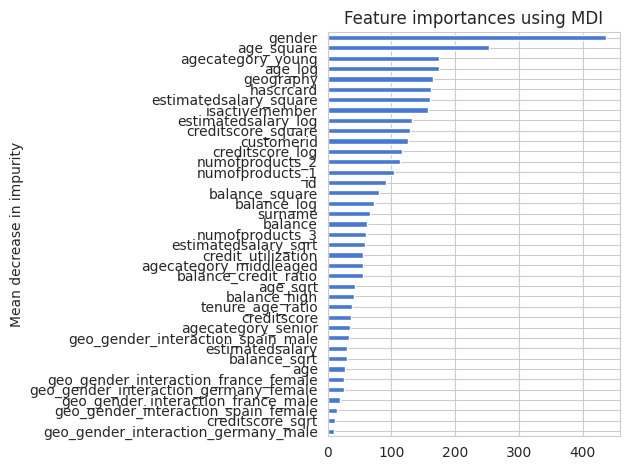

In [18]:
importances = model.feature_importances_

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False)[::-1].plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [19]:
probas = model.predict_proba(X_test)
positive_label_proba = probas[:, 1]
submission['Exited'] = positive_label_proba
submission.to_csv('baseline.csv', index=False)

🚨🚨🚨 
* slightly imbalanced set
* balance column: separate between gaussian variable and < 10
